In [ ]:
!git clone https://github.com/karpathy/minGPT.git

Cloning into 'minGPT'...
remote: Enumerating objects: 175, done.
remote: Total 175 (delta 0), reused 0 (delta 0), pack-reused 175
Receiving objects: 100% (175/175), 1.37 MiB | 24.20 MiB/s, done.
Resolving deltas: 100% (101/101), done.


In [ ]:
!pwd

/content


In [ ]:
%cd minGPT

/content/minGPT


In [ ]:
# ustawienie logowania i jego formatu
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)


In [ ]:
# ustalenie seedu na 42
from mingpt.utils import set_seed
set_seed(42)



In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F

In [ ]:
import math
from torch.utils.data import Dataset

class CharDataset(Dataset):

    def __init__(self, data, block_size):
        chars = list(set(data))
        data_size, vocab_size = len(data), len(chars)
        print('data has %d characters, %d unique.' % (data_size, vocab_size))
        
        self.stoi = { ch:i for i,ch in enumerate(chars) }
        self.itos = { i:ch for i,ch in enumerate(chars) }
        self.block_size = block_size
        self.vocab_size = vocab_size
        self.data = data
    
    def __len__(self):
        return math.ceil(len(self.data) / (self.block_size + 1))

    def __getitem__(self, idx):
        # wybieranie losowego miejsca z datasetu
        i = np.random.randint(0, len(self.data) - (self.block_size + 1))
        chunk = self.data[i:i+self.block_size+1]
        dix = [self.stoi[s] for s in chunk]
        x = torch.tensor(dix[:-1], dtype=torch.long)
        y = torch.tensor(dix[1:], dtype=torch.long)
        return x, y

In [ ]:
block_size = 128 # spatial extent of the model for its context

In [ ]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2021-01-19 22:46:36--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.04s   

2021-01-19 22:46:37 (28.2 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [ ]:


# you can download this file at https://github.com/karpathy/char-rnn/blob/master/data/tinyshakespeare/input.txt
text = open('input.txt', 'r').read() # don't worry we won't run out of file handles
train_dataset = CharDataset(text, block_size) # one line of poem is roughly 50 characters



data has 1115394 characters, 65 unique.


In [ ]:
# inicjalizacja gpt

utworzenie configu do minigpt:


*   ilosc warstw - 8
*   liczba headow atencyjnych dla kazdej warstwy atencyjnej w modelu - 8
*   liczba embeddingow - 512



In [ ]:
from mingpt.model import GPT, GPTConfig
mconf = GPTConfig(train_dataset.vocab_size, train_dataset.block_size,
                  n_layer=8, n_head=8, n_embd=512)
model = GPT(mconf)

01/19/2021 22:46:39 - INFO - mingpt.model -   number of parameters: 2.535219e+07


In [ ]:
import gc
gc.collect() 

20

utworzenie configu do nauki :

*   liczba epok do 15
*   batch size 256 
*   learning rate ustalony na 0.0006 - wspolczynnik predkosci uczenia
*   lr_decay - ustalenie na true, a wiec lr w trakcie uczenia zmniejszany 
*   warmup tokens uzywany do obliczenia nowego lr podczas jego zmniejszania 
*   final tokens uzywany podczas obliczania nowego lr gdy jest ustalony trygonometryczny rozklad lr
*   num workers - liczba workerow uzyta do ladowania danych

In [ ]:
from mingpt.trainer import Trainer, TrainerConfig

# initialize a trainer instance and kick off training
tconf = TrainerConfig(max_epochs=15, batch_size=256, learning_rate=6e-4,
                      lr_decay=True, warmup_tokens=512*20, final_tokens=200*len(train_dataset)*block_size,
                      num_workers=4)
trainer = Trainer(model, train_dataset, None, tconf)
trainer.train()



epoch 1 iter 33: train loss 2.46674. lr 5.999637e-04: 100%|██████████| 34/34 [01:04<00:00,  1.91s/it]
epoch 2 iter 33: train loss 2.41043. lr 5.998533e-04: 100%|██████████| 34/34 [01:04<00:00,  1.89s/it]
epoch 3 iter 33: train loss 2.31192. lr 5.996690e-04: 100%|██████████| 34/34 [01:04<00:00,  1.90s/it]
epoch 4 iter 33: train loss 2.19503. lr 5.994107e-04: 100%|██████████| 34/34 [01:04<00:00,  1.90s/it]
epoch 5 iter 31: train loss 2.08456. lr 5.990979e-04:  94%|█████████▍| 32/34 [01:01<00:03,  1.90s/it]

In [ ]:
# alright, let's sample some character-level shakespear
from mingpt.utils import sample

context = "O God!" #ustalenie kontekstu wg jakiego ma generowac tekst
x = torch.tensor([train_dataset.stoi[s] for s in context], dtype=torch.long)[None,...].to(trainer.device)
y = sample(model, x, 2000, temperature=0.9, sample=True, top_k=5)[0] #temperatura - wspolczynnik jak bardzo model ma eksplorowac a jak bardzo eksploatowac
completion = ''.join([train_dataset.itos[int(i)] for i in y])
print(completion)

#Wnioski

Dobra siec do nauki dzialania gpt. Efekty zas nie sa zbyt realne. Implementacja w dosc prosty sposob.

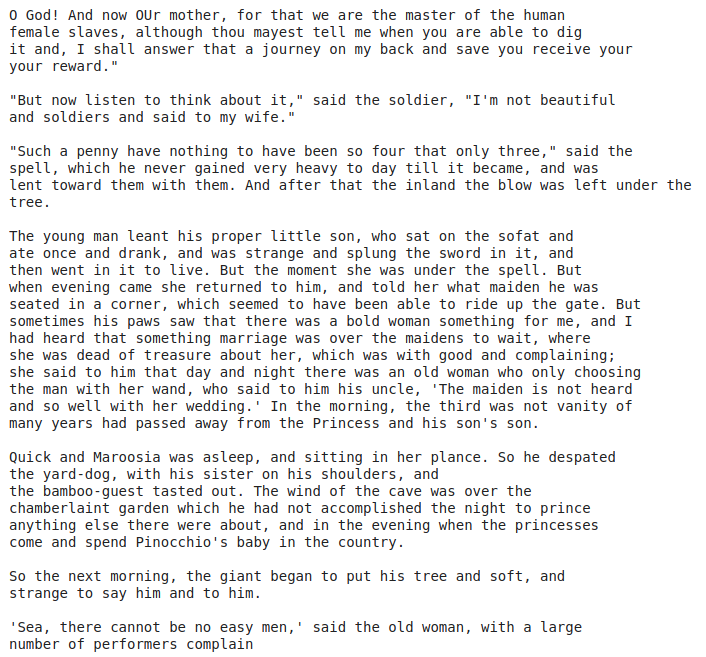